# PageRank Filter After Finding Cleaning Parameters

<p align = "justify">In this appraoch, each spectra is a node and every node is connected to every other node in the graph making it fully connected. To calculate the relationahip weight between each node, we first calculate the euchildean distance between each spectra, using each spectras absorbance values as a vector. We can do this as the intervals between intensity data points remains unchanged across every spectra. We then pass the euchildean distance through the Gaussian kernel function to get a similarity measure between each spectra. This is then used as a relationship weight.

The spectra is cleaned first here, then the graph is constructed before the least central spectra are dropped.

## Importing and Preprocessig Data for Neo4j

Import relevant libraries and import raw data

In [45]:
import sys
sys.path.append('..')  # Adds the parent directory to the path so Python can find the `Cleaning_and_Evaluation` package
from Cleaning_and_Evaluation import *
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

Here we import the neo4j directory and password variables that have been set in our environment

In [13]:
os_name = os.name

if os_name == 'nt':
    password = os.getenv('NEO4J_Password')
    neo4j_directory = os.getenv('NEO4J_Directory')
else:
    password = os.environ['NEO4J_Password']
    neo4j_directory = os.environ['NEO4J_Directory']

Alternatively you can manually input the neo4j directory and password here

In [14]:
# password = "your_neo4j_password"
# neo4j_directory = "your_neo4j_dbms_directory"

In [15]:
df = pd.read_csv("../data/exosomes.raw_spectrum_400-1800.csv")

In [16]:
cleaning_params = {
    'despike': False,
    'baseline_correct': True,
    'smoothing': True,
    'scaling': 'snv',
    'despike_ma': 57,
    'despike_threshold': 3.75,
    'lam': 10 ** 10,
    'window_size': 77,
    'poly_order': 5,
    'p': 0.057
}
spectra_cleaning(df, **cleaning_params)

df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,293,400.22778,-0.745287,201210-1,Normal
1,201210-1-00,294,400.91116,-0.763910,201210-1,Normal
2,201210-1-00,295,401.59454,-0.779497,201210-1,Normal
3,201210-1-00,296,402.27789,-0.792336,201210-1,Normal
4,201210-1-00,297,402.96127,-0.802699,201210-1,Normal


In [17]:
sample = df[df['SurID'] == '210526-3']

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

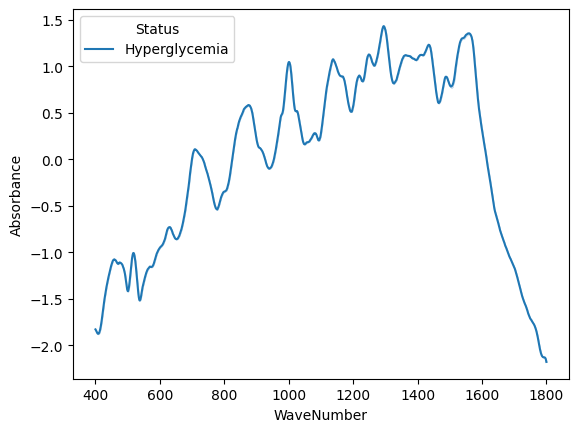

In [18]:
sns.lineplot(data=sample, x='WaveNumber', y='Absorbance', hue='Status', errorbar=('ci', False))

In [19]:
pivoted_df = df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
pivoted_df.columns.name = None

statuses = df[['SpecID', 'Status']].drop_duplicates()

pivoted_df = pd.merge(pivoted_df, statuses, on='SpecID')
pivoted_df = pivoted_df.set_index('SpecID')

pivoted_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,-0.745287,-0.763910,-0.779497,-0.792336,-0.802699,-0.810844,-0.817017,-0.821446,-0.824348,-0.825928,...,-1.785943,-1.808544,-1.841060,-1.885054,-1.942201,-2.014290,-2.103228,-2.211045,-2.339894,Normal
201210-1-01,-0.617531,-0.594327,-0.573249,-0.554065,-0.536565,-0.520554,-0.505851,-0.492295,-0.479737,-0.468043,...,-1.712595,-1.709091,-1.706646,-1.705572,-1.706208,-1.708913,-1.714075,-1.722105,-1.733443,Normal
201210-1-02,0.279130,0.245740,0.216969,0.192423,0.171726,0.154522,0.140473,0.129257,0.120572,0.114132,...,-0.972497,-0.973056,-0.974898,-0.978359,-0.983801,-0.991616,-1.002229,-1.016094,-1.033699,Normal
201210-1-03,-0.130300,-0.117785,-0.108905,-0.103220,-0.100313,-0.099799,-0.101317,-0.104530,-0.109127,-0.114822,...,-1.441462,-1.441818,-1.443004,-1.445245,-1.448783,-1.453880,-1.460817,-1.469898,-1.481444,Normal
201210-1-04,0.863737,0.786794,0.717730,0.656051,0.601280,0.552956,0.510634,0.473885,0.442297,0.415471,...,-2.077745,-2.082203,-2.085654,-2.087980,-2.089053,-2.088731,-2.086860,-2.083272,-2.077785,Normal


In [20]:
status_df = df.groupby('SpecID')[['SurID', 'Status']].first()
status_df.head()

,SurID,Status
SpecID,,
201210-1-00,201210-1,Normal
201210-1-01,201210-1,Normal
201210-1-02,201210-1,Normal
201210-1-03,201210-1,Normal
201210-1-04,201210-1,Normal


>#### **Calculate an adjacency matrix using a Gaussian Kernel**

In [21]:
from scipy.spatial.distance import pdist, squareform

# Drop the 'Status' column as it is not numeric
X = pivoted_df.drop(columns=['Status'])

# Calculate pairwise Euclidean distances
distances = pdist(X.values, metric='euclidean')

# Convert the condensed distances to a square matrix form
distance_matrix = squareform(distances)

In [22]:
def gaussian_kernel(distances, sigma):
    return np.exp(-distances**2 / (2 * sigma**2))

# Sigma is the bandwidth parameter
sigma = 25 # Adjust sigma as needed
kernel_matrix = gaussian_kernel(distance_matrix, sigma)

# Convert the kernel matrix to a DataFrame
kernel_df = pd.DataFrame(kernel_matrix, index=pivoted_df.index, columns=pivoted_df.index)

display(kernel_df.head())
kernel_df.shape

SpecID,201210-1-00,201210-1-01,201210-1-02,201210-1-03,201210-1-04,201210-1-05,201210-1-06,201210-1-07,201210-1-09,201210-1-10,...,210526-3-40,210526-3-41,210526-3-42,210526-3-43,210526-3-44,210526-3-45,210526-3-46,210526-3-47,210526-3-48,210526-3-49
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.000000,0.705506,0.149128,0.137817,0.236651,0.091506,0.043180,0.043467,0.034771,0.053286,...,0.313678,0.298789,0.290766,0.297672,0.301407,0.299049,0.300273,0.285468,0.307596,0.307324
201210-1-01,0.705506,1.000000,0.207474,0.145345,0.345362,0.158192,0.078143,0.075354,0.059139,0.085962,...,0.227139,0.224479,0.218578,0.215741,0.216791,0.218106,0.221036,0.210539,0.226681,0.224732
201210-1-02,0.149128,0.207474,1.000000,0.263179,0.082726,0.068559,0.052325,0.055449,0.054394,0.056298,...,0.058283,0.056605,0.057451,0.056496,0.056484,0.055484,0.058110,0.065880,0.057626,0.055873
201210-1-03,0.137817,0.145345,0.263179,1.000000,0.093195,0.052912,0.043819,0.044406,0.038970,0.038641,...,0.148954,0.148217,0.140595,0.141313,0.143605,0.140899,0.144088,0.169873,0.148005,0.136324
201210-1-04,0.236651,0.345362,0.082726,0.093195,1.000000,0.617596,0.285924,0.253684,0.190507,0.269141,...,0.154288,0.165091,0.161842,0.150607,0.148305,0.153799,0.155994,0.150643,0.156272,0.168504


(3045, 3045)

**Construct the node and edge import files with the required Admin Import Headers**

In [23]:
relationship_df = kernel_df.reset_index()
relationship_df = relationship_df.melt(id_vars='SpecID', var_name=':END_ID', value_name='Weight:float')
relationship_df = relationship_df.rename(columns={'SpecID': ':START_ID'})
relationship_df[':TYPE'] = 'LINK'

Drop Relationships a node has with itself, along with repeat relationships.

In [24]:
relationship_df = relationship_df[relationship_df[":START_ID"] != relationship_df[":END_ID"]]
relationship_df = relationship_df[relationship_df[":START_ID"] < relationship_df[":END_ID"]]  # Drops redundant relationships
relationship_df.head()

,:START_ID,:END_ID,Weight:float,:TYPE
3045,201210-1-00,201210-1-01,0.705506,LINK
6090,201210-1-00,201210-1-02,0.149128,LINK
6091,201210-1-01,201210-1-02,0.207474,LINK
9135,201210-1-00,201210-1-03,0.137817,LINK
9136,201210-1-01,201210-1-03,0.145345,LINK


In [25]:
node_df = status_df.reset_index()
node_df.rename(columns={'SpecID':'SpecID:ID', 'Status':'Status:LABEL', 'SurID':'SurID:LABEL'}, inplace=True)
node_df.head()

,SpecID:ID,SurID:LABEL,Status:LABEL
0,201210-1-00,201210-1,Normal
1,201210-1-01,201210-1,Normal
2,201210-1-02,201210-1,Normal
3,201210-1-03,201210-1,Normal
4,201210-1-04,201210-1,Normal


In [26]:
node_df.to_csv(f"{neo4j_directory}/import/nodes.csv", index=False)

In [27]:
relationship_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

In [28]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

## Building Graph and Running Graph Algorithms

Then run the admin import command.

In [29]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
Neo4j version: 5.18.0
Importing the contents of these files into C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\data\databases\neo4j:
Nodes:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\nodes.csv

Relationships:
  C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv


Available resources:
  Total machine memory: 31.86GiB
  Free machine memory: 19.05GiB
  Max heap memory : 910.5MiB
  Max worker threads: 8
  Configured max memory: 16.43GiB
  High parallel IO: true

Cypher type normalization is enabled (disable with --normalize-types=false):
  Property type of 'Weight' normalized from 'float' --> 'double' in C:\Users\stang\.Neo4jDesktop\relate-data\dbmss\dbms-d0a05d27-d2ec-404f-a7c3-e7f4b6a97351\import\relationships.csv

Import starting 2024-04-21 15:10:01.902+0100
  Estimated number of nodes: 3.05 k
  Estimated numbe

In [28]:
if os_name != 'nt':
    command = [
        './bin/neo4j', 'restart'
    ]

    result = subprocess.run(command, cwd=neo4j_directory, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Check if the command was successful
    if result.returncode == 0:
        print("Restart successful")
        print(result.stdout)
    else:
        print("Error during restart:")
        print(result.stderr)

Restart successful
b'Stopping Neo4j........ stopped.\nConfiguration file validation successful (with warnings).\nDirectories in use:\nhome:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5\nconfig:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/conf\nlogs:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/logs\nplugins:      /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/plugins\nimport:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import\ndata:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data\ncertificates: /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ff

Run and connect to the Neo4j Database

In [30]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Password defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**We will calculate the centrality rank of each spectra within it's surface**

In [32]:
surfaces = status_df['SurID'].unique()

In [33]:
pagerank_dfs = []

def project_graph(tx, surface):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      $nodeLabel,
      {
        LINK: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query, nodeLabel=surface)

def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

for surface in surfaces:
    with driver.session() as session:
        session.execute_write(project_graph, surface)
        pagerank_results = session.execute_read(run_pagerank_centrality)
        pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'PageRank'])
        pagerank_df['SurfacePageRankRank'] = pagerank_df['PageRank'].rank(method='dense', ascending=False)  # Get the rank of centrality of each spectra within the surface
        pagerank_df['ReverseSurfacePageRankRank'] = pagerank_df['PageRank'].rank(method='dense')  # Get the rank of centrality of each spectra within the surface
        pagerank_dfs.append(pagerank_df)
        session.execute_write(delete_projection)


In [34]:
close_driver()

In [35]:
pagerank_results = pd.concat(pagerank_dfs).rename(columns={'name':'SpecID'})
pagerank_results.head()

,SpecID,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-48,1.083999,1.0,49.0
1,201210-1-47,1.083902,2.0,48.0
2,201210-1-28,1.082502,3.0,47.0
3,201210-1-46,1.080472,4.0,46.0
4,201210-1-29,1.079371,5.0,45.0


##### **Test how different Centrality Ranks affect Predictive Performance**

In [36]:
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.ensemble import ExtraTreesClassifier

In [37]:
df = df.merge(pagerank_results, on='SpecID')
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,-0.745287,201210-1,Normal,0.564425,46.0,4.0
1,201210-1-00,294,400.91116,-0.763910,201210-1,Normal,0.564425,46.0,4.0
2,201210-1-00,295,401.59454,-0.779497,201210-1,Normal,0.564425,46.0,4.0
3,201210-1-00,296,402.27789,-0.792336,201210-1,Normal,0.564425,46.0,4.0
4,201210-1-00,297,402.96127,-0.802699,201210-1,Normal,0.564425,46.0,4.0


In [38]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [39]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,-0.745287,-0.763910,-0.779497,-0.792336,-0.802699,-0.810844,-0.817017,-0.821446,-0.824348,-0.825928,...,-1.808544,-1.841060,-1.885054,-1.942201,-2.014290,-2.103228,-2.211045,-2.339894,201210-1,Normal
201210-1-01,-0.617531,-0.594327,-0.573249,-0.554065,-0.536565,-0.520554,-0.505851,-0.492295,-0.479737,-0.468043,...,-1.709091,-1.706646,-1.705572,-1.706208,-1.708913,-1.714075,-1.722105,-1.733443,201210-1,Normal
201210-1-02,0.279130,0.245740,0.216969,0.192423,0.171726,0.154522,0.140473,0.129257,0.120572,0.114132,...,-0.973056,-0.974898,-0.978359,-0.983801,-0.991616,-1.002229,-1.016094,-1.033699,201210-1,Normal
201210-1-03,-0.130300,-0.117785,-0.108905,-0.103220,-0.100313,-0.099799,-0.101317,-0.104530,-0.109127,-0.114822,...,-1.441818,-1.443004,-1.445245,-1.448783,-1.453880,-1.460817,-1.469898,-1.481444,201210-1,Normal
201210-1-04,0.863737,0.786794,0.717730,0.656051,0.601280,0.552956,0.510634,0.473885,0.442297,0.415471,...,-2.082203,-2.085654,-2.087980,-2.089053,-2.088731,-2.086860,-2.083272,-2.077785,201210-1,Normal


In [40]:
et = ExtraTreesClassifier(random_state=1234)
evaluate_model(wavelength_df, et)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6160 +/- 0.0978
ExtraTreesClassifier Cross-Validation Precision: 0.6286 +/- 0.0952
ExtraTreesClassifier Cross-Validation Recall: 0.6303 +/- 0.1392
ExtraTreesClassifier Cross-Validation F1-Score: 0.5956 +/- 0.1193


#### **Only keep the top k most central spectra**

In [41]:
representative_df = df[df['SurfacePageRankRank'] <= 40]
representative_df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
12294,201210-1-06,293,400.22778,1.890824,201210-1,Normal,0.923351,40.0,10.0
12295,201210-1-06,294,400.91116,1.941490,201210-1,Normal,0.923351,40.0,10.0
12296,201210-1-06,295,401.59454,1.988532,201210-1,Normal,0.923351,40.0,10.0
12297,201210-1-06,296,402.27789,2.032146,201210-1,Normal,0.923351,40.0,10.0
12298,201210-1-06,297,402.96127,2.072524,201210-1,Normal,0.923351,40.0,10.0


In [42]:
representative_wavelength_df = prepare_wavelength_df(representative_df, 'Absorbance')
evaluate_model(representative_wavelength_df, et)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6441 +/- 0.0644
ExtraTreesClassifier Cross-Validation Precision: 0.6202 +/- 0.0951
ExtraTreesClassifier Cross-Validation Recall: 0.6490 +/- 0.1247
ExtraTreesClassifier Cross-Validation F1-Score: 0.6016 +/- 0.1096


#### **Alternatively, try dropping the least central spectra from each Surface**

In [43]:
representative_df = df[df['ReverseSurfacePageRankRank'] >= 5]
representative_df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
8196,201210-1-04,293,400.22778,0.863737,201210-1,Normal,0.569536,45.0,5.0
8197,201210-1-04,294,400.91116,0.786794,201210-1,Normal,0.569536,45.0,5.0
8198,201210-1-04,295,401.59454,0.717730,201210-1,Normal,0.569536,45.0,5.0
8199,201210-1-04,296,402.27789,0.656051,201210-1,Normal,0.569536,45.0,5.0
8200,201210-1-04,297,402.96127,0.601280,201210-1,Normal,0.569536,45.0,5.0


In [44]:
representative_wavelength_df = prepare_wavelength_df(representative_df, 'Absorbance')
evaluate_model(representative_wavelength_df, et)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6347 +/- 0.1052
ExtraTreesClassifier Cross-Validation Precision: 0.6502 +/- 0.1047
ExtraTreesClassifier Cross-Validation Recall: 0.6516 +/- 0.1503
ExtraTreesClassifier Cross-Validation F1-Score: 0.6124 +/- 0.1305


##### **Here we only keep the top 80% of most central spectra for building our model**

We look at the top and bottom ten percent to visualise the effectiveness of this method

In [46]:
median_ranks = df.groupby('SurID')['SurfacePageRankRank'].transform(lambda x: x.quantile(0.8))

top_ten = df.groupby('SurID')['SurfacePageRankRank'].transform(lambda x: x.quantile(0.1))
bottom_ten = df.groupby('SurID')['SurfacePageRankRank'].transform(lambda x: x.quantile(0.9))

filtered_df = df[df['SurfacePageRankRank'] <= median_ranks]
top_df = df[df['SurfacePageRankRank'] <= top_ten]
bottom_df = df[df['SurfacePageRankRank'] >= bottom_ten]

In [47]:
filtered_df['SurID'].unique()

array(['201210-1', '201210-2', '210114-1', '210114-2', '210120-1',
       '210120-2', '210121-1', '210121-2', '210211-1', '210211-2',
       '210217-1', '210217-2', '210218-1', '210224-1', '210225-1',
       '210225-2', '210303-1', '210303-2', '210304-1', '210304-2',
       '210310-1', '210310-2', '210311-1', '210311-2', '210315-1',
       '210315-2', '210318-1', '210318-2', '210324-1', '210324-2',
       '210325-1', '210325-2', '210331-1', '210401-1', '210415-1',
       '210415-2', '210419-1', '210419-2', '210421-1', '210407-1',
       '210407-2', '210414-1', '210414-3', '210414-2', '210428-1',
       '210428-2', '210428-3', '210429-1', '210504-1', '210504-2',
       '210504-3', '210505-1', '210510-1', '210510-2', '210511-1',
       '210518-1', '210519-1', '210519-2', '210519-3', '210524-1',
       '210526-1', '210526-2', '210526-3'], dtype=object)

Lets look at a specific sample from the above list to get an idea of what we are doing

In [48]:
surface = "201210-1"

In [49]:
fil_sample = top_df[top_df['SurID'] == surface]
opp_sample = bottom_df[bottom_df['SurID'] == surface]

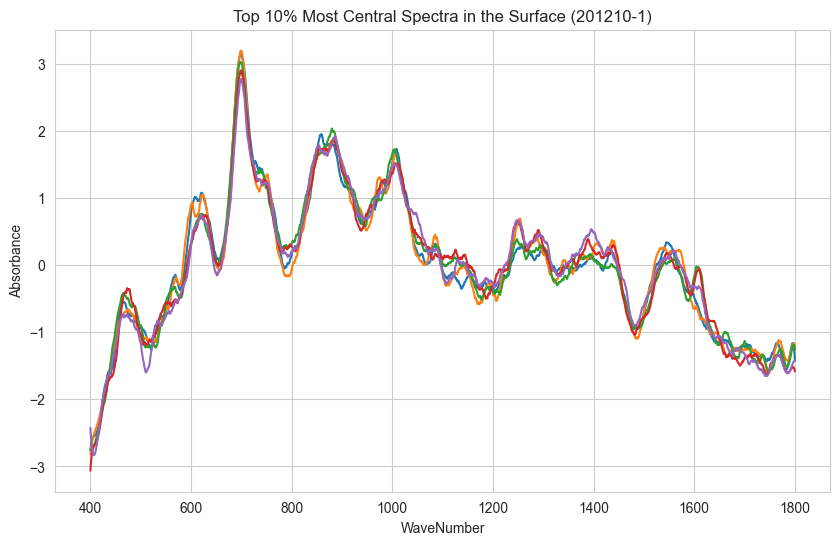

In [50]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create the line plot
sns.lineplot(data=fil_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

# Display the plot
plt.title('Top 10% Most Central Spectra in the Surface (201210-1)')
plt.show()

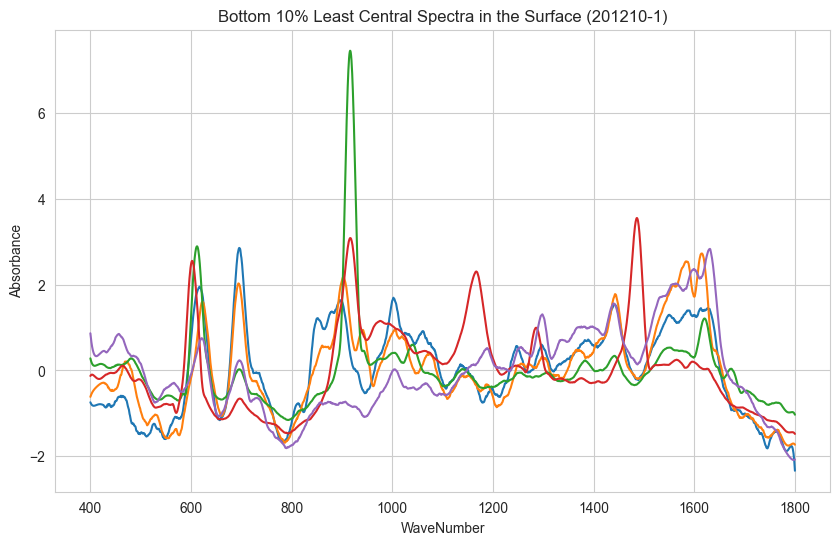

In [51]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

sns.lineplot(data=opp_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

# Display the plot
plt.title('Bottom 10% Least Central Spectra in the Surface (201210-1)')
plt.show()

In [52]:
filtered_representative_wavelength_df = prepare_wavelength_df(filtered_df, 'Absorbance')
evaluate_model(filtered_representative_wavelength_df, et)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6405 +/- 0.1139
ExtraTreesClassifier Cross-Validation Precision: 0.6428 +/- 0.0971
ExtraTreesClassifier Cross-Validation Recall: 0.6525 +/- 0.1306
ExtraTreesClassifier Cross-Validation F1-Score: 0.6051 +/- 0.1134


## PageRank Cutofff

Instead of doing the median, we will try just dropping spectra below a certain centrality threshold

In [53]:
PageRank_filter = df[df['PageRank'] > 0.93]
opp_PageRank_filter = df[df['PageRank'] <= 0.93]

In [54]:
fil_sample = PageRank_filter[PageRank_filter['SurID'] == '201210-1']
opp_sample = opp_PageRank_filter[opp_PageRank_filter['SurID'] == '201210-1']

Instead of visualising the top and bottom ten percent, here we visualise everything we are keeping versus everything we are throwing away

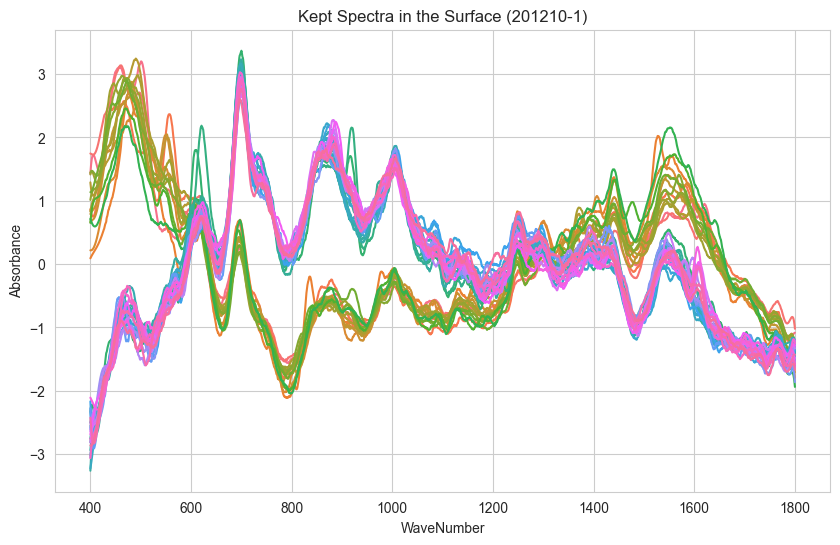

In [59]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

sns.lineplot(data=fil_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

# Display the plot
plt.title('Kept Spectra in the Surface (201210-1)')
plt.show()

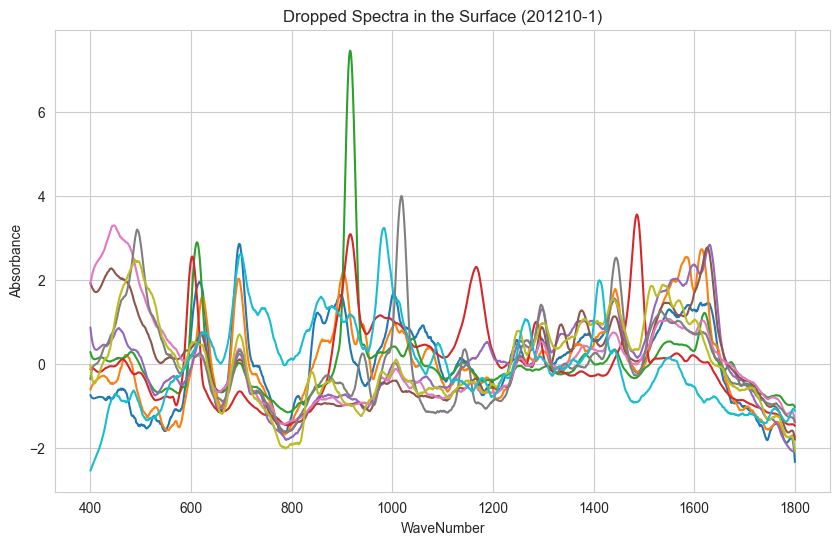

In [60]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

sns.lineplot(data=opp_sample, x='WaveNumber', y='Absorbance', hue='SpecID', errorbar=('ci', False), legend=False)

# Display the plot
plt.title('Dropped Spectra in the Surface (201210-1)')
plt.show()

In [61]:
filtered_representative_wavelength_df = prepare_wavelength_df(PageRank_filter, 'Absorbance')
evaluate_model(filtered_representative_wavelength_df, et)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6820 +/- 0.1069
ExtraTreesClassifier Cross-Validation Precision: 0.6602 +/- 0.1119
ExtraTreesClassifier Cross-Validation Recall: 0.6569 +/- 0.1217
ExtraTreesClassifier Cross-Validation F1-Score: 0.6354 +/- 0.1191


Here we perfrom a search to find what threshold yields the best accuracy

In [63]:
def compare_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)

    # Displaying the results
    return np.mean(scores['test_accuracy'])

In [64]:
percentage = []
acurate = []

for num in np.arange(0.86, 0.95, 0.01):
    PageRank_filter = df[df['PageRank'] > num]
    filtered_representative_wavelength_df = prepare_wavelength_df(PageRank_filter, 'Absorbance')
    accuracy = compare_extra_trees(filtered_representative_wavelength_df)
    percentage.append(num)
    acurate.append(accuracy)

test_results = pd.DataFrame({'Percentage Cutoff':percentage, 'Accuracy':acurate})

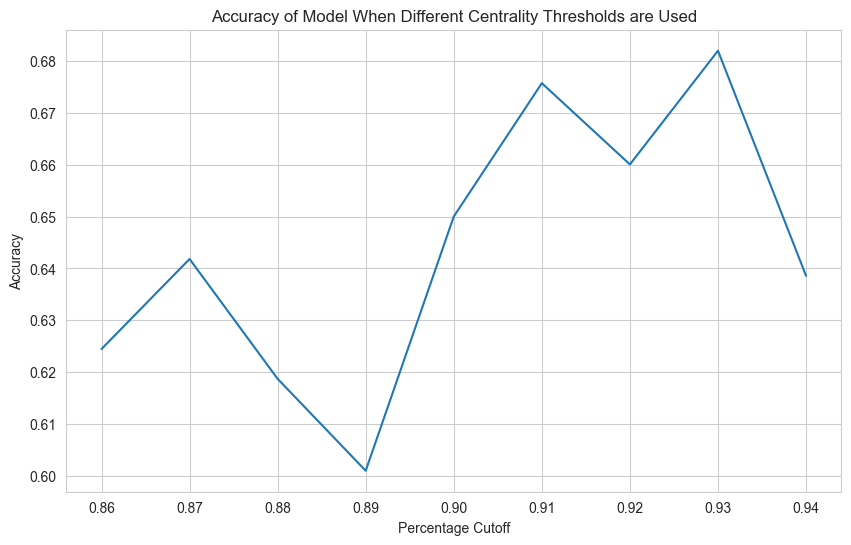

In [65]:
# Set the size of the plot
plt.figure(figsize=(10, 6))

sns.lineplot(data=test_results, y='Accuracy', x='Percentage Cutoff')

# Display the plot
plt.title('Accuracy of Model When Different Centrality Thresholds are Used')
plt.show()

In [66]:
PageRank_filter.groupby('Status')['SpecID'].nunique()

Status
Hyperglycemia    637
Hypoglycemia     759
Normal           763
Name: SpecID, dtype: int64